In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.stattools import adfuller,acf, pacf
from statsmodels.tsa.arima_model import ARIMA
import statsmodels.api as sm
from pylab import rcParams

In [ ]:
# importing libraries
import math
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import acf, pacf
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import *
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
#from statsmodels.tsa.ar_model import AutoReg
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima_model import ARIMA
import warnings
warnings.filterwarnings("ignore")

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
etf=pd.read_csv('/content/drive/Shareddrives/Capstone B1/Spinnaker Data/US Sector Inst ETF.csv')
institutional=pd.read_csv('/content/drive/Shareddrives/Capstone B1/Spinnaker Data/US Sector Institutional MF.csv') 
retail=pd.read_csv('/content/drive/Shareddrives/Capstone B1/Spinnaker Data/US Sector Retail MF.csv')

In [ ]:
missingAsset = 'Infrastructure-North America-USA-North America-Equity'

etf.drop(etf[etf['AssetClass'] == missingAsset].index, inplace=True)
institutional.drop(institutional[institutional['AssetClass'] == missingAsset].index, inplace=True)
retail.drop(retail[retail['AssetClass'] == missingAsset].index, inplace=True)

In [ ]:
# define a function for preprocessing dataset
def preprocessing(df): 
  # trim AssetClass names
  df['AssetClass'] = df['AssetClass'].str.replace('-North America-USA-North America-Equity', '')

  # convert ReportDate to datetime 
  df['ReportDate'] = pd.to_datetime(df["ReportDate"])
  # feature engineering
  df['M16'] = df['AssetsEnd'].rolling(16).mean()
  df['M50'] = df['AssetsEnd'].rolling(50).mean()

  df['M16'] = df['M16'].fillna(method="bfill")
  df['M50'] = df['M50'].fillna(method="bfill")

  # set ReportDate as index
  df.sort_values("ReportDate", inplace=True)
  df.set_index('ReportDate', inplace=True)
  return df

In [ ]:
etf = preprocessing(etf)
institutional = preprocessing(institutional)
retail = preprocessing(retail)

In [ ]:
def group_by_assetclass(df):
    arraysDict = {}
    grouped = df.groupby(df['AssetClass'])
    for i in df['AssetClass']:
        arraysDict['model_{0}'.format(i)] = grouped.get_group(i)
    return arraysDict

# carry-out the train-test split of the data and keep the last 58-weeks as test data.
def split(arraysDict, observations=116):
  global train
  global test
  train_dict = {}
  test_dict = {}
  for key in arraysDict.keys():
      # columns to drop and split train test sets
      arraysDict.get(key).drop(['AssetClass'], axis = 1, inplace = True)
      arraysDict.get(key).dropna()

      #train_data, test_data = df_log[3:int(len(df_log)*0.9)], df_log[int(len(df_log)*0.9):]

      train_dict[key] = arraysDict.get(key).iloc[:-observations,:]
      train_dict[key].replace([np.inf, -np.inf], np.nan, inplace=True)
      train_dict[key] = train_dict[key].dropna()
      test_dict[key] = arraysDict.get(key).iloc[-observations:,:]
      test_dict[key].replace([np.inf, -np.inf], np.nan, inplace=True)
      test_dict[key] = test_dict[key].dropna()
  return train_dict, test_dict

In [ ]:
arraysDict_etf = group_by_assetclass(etf)
arraysDict_institutional = group_by_assetclass(institutional)
arraysDict_retail = group_by_assetclass(retail)

In [ ]:
train_etf_dict, test_etf_dict = split(arraysDict_etf)
train_institutional_dict, test_institutional_dict = split(arraysDict_institutional)
train_retail_dict, test_retail_dict = split(arraysDict_retail)

In [ ]:
# Run through Var model on every train set, put them in a list with a name
def run_model(train_dict,test_dict):
    short_window = 8
    long_window = 20
    signals_list = []
    predicted_results = []
    for (key1, key2) in zip(train_dict.keys(),test_dict.keys()):
        sc1 = StandardScaler()
        sc2 = StandardScaler()
        columns = ['Flow','FlowPct','PortfolioChangePct','M16','M50']
        train_dict.get(key1)[columns] = sc1.fit_transform(train_dict.get(key1)[columns])
        test_dict.get(key2)[columns] = sc1.transform(test_dict.get(key2)[columns])
        train_dict.get(key1)['AssetsEnd'] = sc2.fit_transform(train_dict.get(key1)[['AssetsEnd']])
        model = SARIMAX(endog=train_dict.get(key1)['AssetsEnd'],exog=train_dict.get(key1)[columns],order=(2,0,0),seasonal_order=(0,1,2,16),trend=[1,0,1,1],trend_offset=7,enforce_invertibility=False,enforce_stationarity=False,start_params=[0,0,1,0,1,2,1,2])
        model_fit = model.fit(disp=0,maxiter=50,cov_type="robust",method="lbfgs")
        future = model_fit.forecast(steps=len(test_dict.get(key2)),exog = test_dict.get(key2)[columns],dynamic=False)
        future = sc2.inverse_transform(future.values.reshape(-1,1))
        future = pd.Series(future.reshape(-1),name='predicted_mean',index=test_dict.get(key2)["AssetsEnd"].index)
        predicted_results.append(future)
        #Create trading signals   
        signals = pd.DataFrame(index=future.index)
        signals['signal'] = 0.0

        signals['short_mavg'] = future.rolling(window=short_window, min_periods=1, center=False).mean()
        signals['long_mavg'] = future.rolling(window=long_window, min_periods=1, center=False).mean()
        signals['signal'][short_window:] = np.where(signals['short_mavg'][short_window:] 
                                            > signals['long_mavg'][short_window:], 1.0, 0.0)   
        signals['positions'] = signals['signal'].diff()
        signals_list.append(signals)

    # return lists
    return predicted_results, signals_list


In [ ]:
def get_signal(test_dict):
    short_window = 8
    long_window = 20
    signals_list = []
    for key in test_dict.keys():
        signals_2 = pd.DataFrame(index=test_dict.get(key)["AssetsEnd"].index)
        signals_2['signal'] = 0.0

        signals_2['short_mavg'] = test_dict.get(key)["AssetsEnd"].rolling(window=short_window, min_periods=1, center=False).mean()
        signals_2['long_mavg'] = test_dict.get(key)["AssetsEnd"].rolling(window=long_window, min_periods=1, center=False).mean()
        signals_2['signal'][short_window:] = np.where(signals_2['short_mavg'][short_window:] 
                                            > signals_2['long_mavg'][short_window:], 1.0, 0.0)   
        signals_2['positions'] = signals_2['signal'].diff()
        signals_list.append(signals_2)
    return signals_list

In [ ]:
test_signals_list_etf = get_signal(test_etf_dict)
test_signals_list_institutional = get_signal(test_institutional_dict)
test_signals_list_retail = get_signal(test_retail_dict)

In [ ]:
predicted_results_etf, signals_list_etf= run_model(train_etf_dict,test_etf_dict)
predicted_results_institutional, signals_list_institutional= run_model(train_institutional_dict,test_institutional_dict)
predicted_results_retail, signals_list_retail= run_model(train_retail_dict,test_retail_dict)

In [ ]:
from sklearn import metrics
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

# Evaluate the forecasts by calculating the RMSE of predicted assetends and actual assetends in the test dataset
def get_actual_assetend(test_dict):
    actual_assetends = []
    for key in test_dict:
        actual_assetends.append(test_dict.get(key)['AssetsEnd'])
    return actual_assetends

def get_evaluation(predicted_assetends, actual_assetends):
    mse = []
    for i, j in zip(predicted_assetends, actual_assetends):
        mse.append(mean_squared_error(i, j))
    return mse

def get_auc(test_signal_list, future_signal_list):
    auc = []
    for i, j in zip(test_signal_list, future_signal_list):
        auc.append(metrics.roc_auc_score(i['signal'], j['signal']))
    return auc

In [ ]:
actual_assetends_etf = get_actual_assetend(test_etf_dict)
actual_assetends_institutional = get_actual_assetend(test_institutional_dict)
actual_assetends_retail = get_actual_assetend(test_retail_dict)

In [ ]:
mse_etf = get_evaluation(predicted_results_etf, actual_assetends_etf)
mse_institutional = get_evaluation(predicted_results_institutional, actual_assetends_institutional)
mse_retail = get_evaluation(predicted_results_retail, actual_assetends_retail)

In [ ]:
data = {'Etf': mse_etf, 'Institutional': mse_institutional, 'Retail': mse_retail}
mse_table = pd.DataFrame(data = data, index = model_name_etf)
mse_table

,Etf,Institutional,Retail
model_Utilities,1.012354e+08,9.688173e+07,2.671870e+07
model_Commodities/Materials,1.726491e+08,1.777422e+08,1.506078e+08
model_Consumer Goods,3.050750e+07,5.274480e+07,3.482008e+06
model_Energy,9.074193e+07,2.618927e+07,1.295298e+07
model_Financials,3.170412e+07,2.714843e+07,4.386883e+08
model_Health Care/Biotech,4.328380e+08,4.397761e+08,1.860628e+09
model_Industrials,1.203487e+07,2.505699e+07,2.886196e+09
model_Large Cap Blend,4.957666e+09,5.961074e+10,1.519108e+07
model_Large Cap Growth,4.597751e+08,3.805982e+08,5.239626e+02
model_Telecom,7.881575e+04,1.513959e+05,9.743626e+06


Text(0.5, 1.0, 'SARIMAX model with assetend prediction on each assetclass')

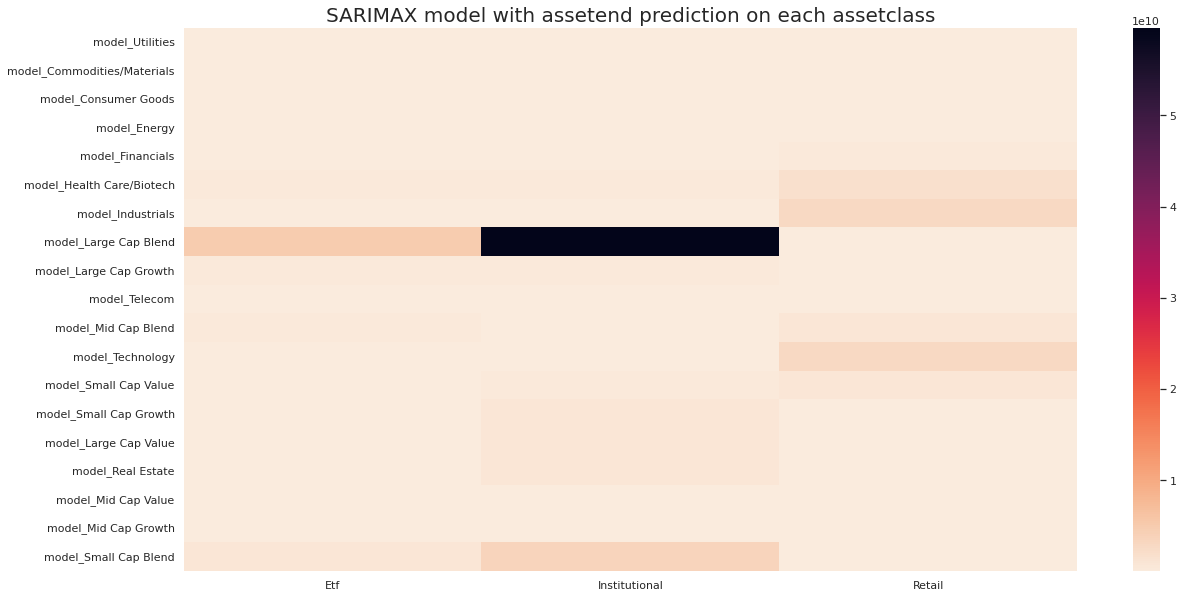

In [ ]:
cmap = sns.cm.rocket_r
ax = sns.heatmap(mse_table,cmap = cmap)
sns.set(rc = {'figure.figsize':(20,10)})
ax.set_title('SARIMAX model with assetend prediction on each assetclass', fontsize =20)

In [ ]:
auc_etf = get_auc(test_signals_list_etf, signals_list_etf)
auc_institutional = get_auc(test_signals_list_institutional, signals_list_etf)
auc_retail = get_auc(test_signals_list_retail, signals_list_etf)

In [ ]:
data = {'Etf': auc_etf, 'Institutional': auc_institutional, 'Retail': auc_retail}
auc_table = pd.DataFrame(data = data, index = model_name_etf)
auc_table

,Etf,Institutional,Retail
model_Utilities,0.450820,0.458333,0.548513
model_Commodities/Materials,0.440000,0.444444,0.450000
model_Consumer Goods,0.575368,0.575368,0.620098
model_Energy,0.678922,0.634545,0.458333
model_Financials,0.684351,0.683817,0.820312
model_Health Care/Biotech,0.601852,0.600000,0.598214
model_Industrials,0.653639,0.653639,0.793103
model_Large Cap Blend,0.768293,0.744444,0.677419
model_Large Cap Growth,0.658570,0.692577,0.595987
model_Telecom,0.547181,0.547181,0.625632


Text(0.5, 1.0, 'SARIMAX model with auc evaluation on each assetclass')

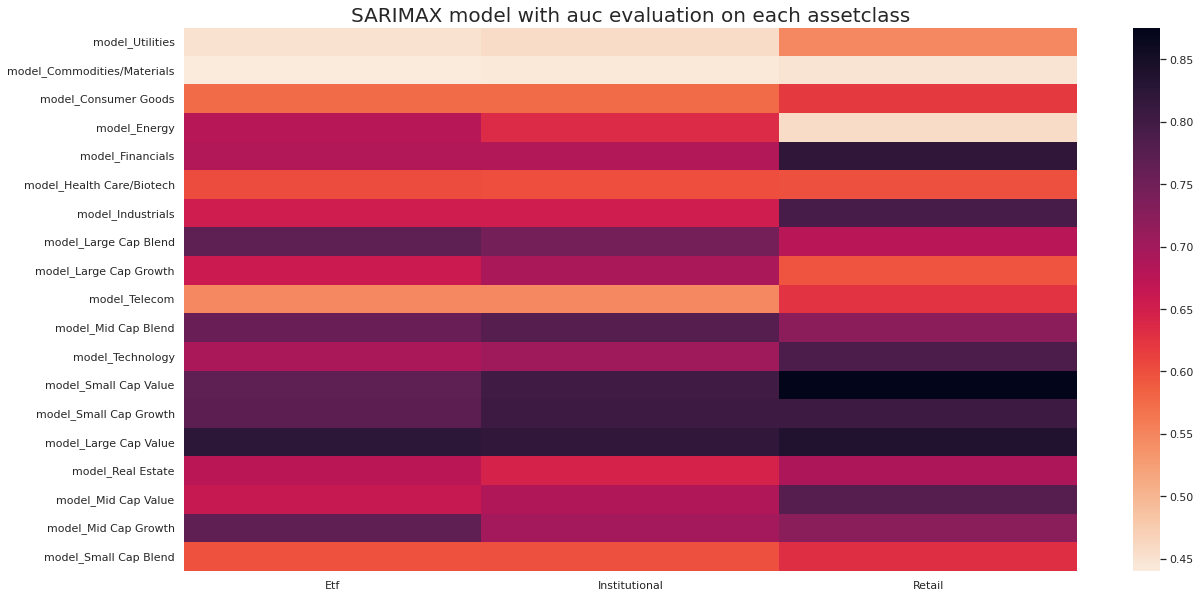

In [ ]:
cmap = sns.cm.rocket_r
ax = sns.heatmap(auc_table,cmap = cmap)
sns.set(rc = {'figure.figsize':(20,10)})
ax.set_title('SARIMAX model with auc evaluation on each assetclass', fontsize =20)

## Creating Charts


In [ ]:
plt.rcParams.update(plt.rcParamsDefault)

In [ ]:
# Check the index of asset class in predicted result list
print(list(test_etf_dict).index('model_Technology'))

11


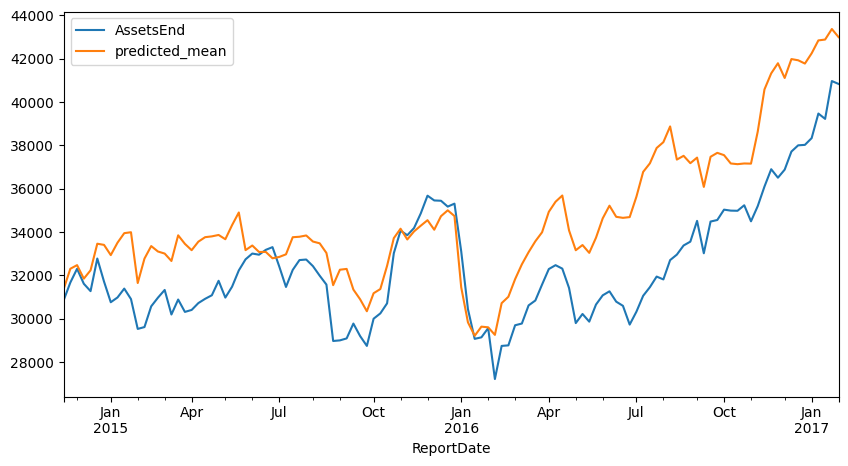

In [ ]:
ans = pd.concat([test_etf_dict.get('model_Technology')["AssetsEnd"],predicted_results_etf[11]],axis=1)
ans.plot(figsize=(10, 5))

<Figure size 640x480 with 0 Axes>

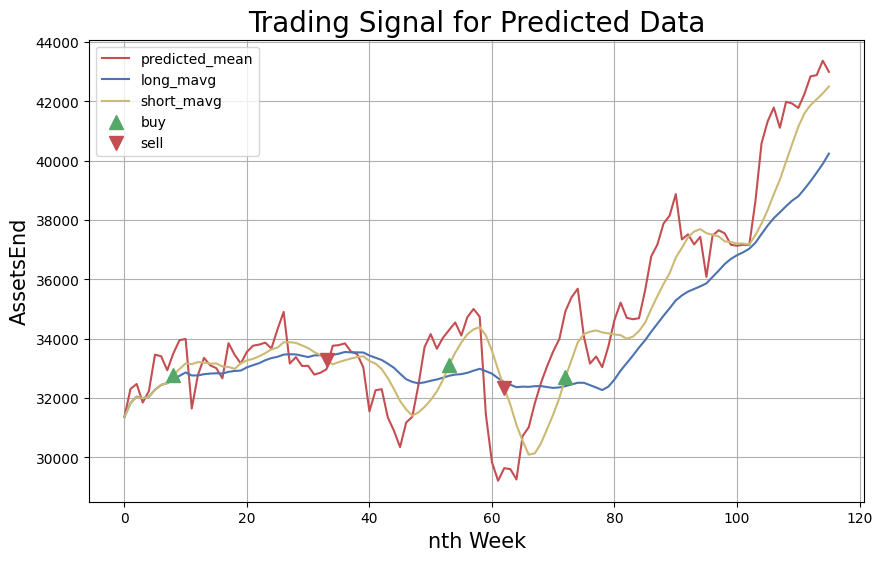

In [ ]:
#Reset Index for Labels
signals = signals_list_etf[11].reset_index(drop=True)
predicted_results =  predicted_results_etf[11].reset_index(drop=True)

import matplotlib.pyplot as plt
plt.clf()
plt.figure(figsize=(10,6))
predicted_results.plot(color='r')
signals['long_mavg'].plot(color = 'b',label = 'long_mavg')
signals['short_mavg'].plot(color = 'y',label = 'short_mavg')
plt.plot(signals.loc[signals['positions'] == 1.0].index, 
         signals['short_mavg'][signals['positions']== 1.0],
         '^', markersize=10, color='g', label = 'buy')
plt.plot(signals.loc[signals['positions'] == -1.0].index, 
         signals['short_mavg'][signals['positions']== -1.0],
         'v', markersize=10, color='r', label = 'sell')

plt.ylabel('AssetsEnd', fontsize = 15)
plt.xlabel('nth Week', fontsize = 15 )
plt.title('Trading Signal for Predicted Data', fontsize = 20)
plt.legend()
plt.grid()
plt.show()

<Figure size 640x480 with 0 Axes>

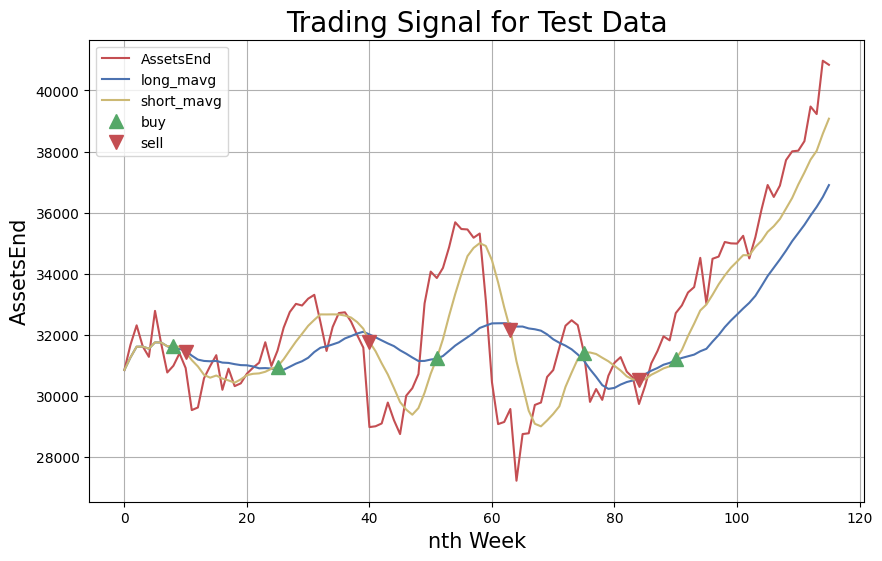

In [ ]:
#Reset Index for Labels
signals = test_signals_list_etf[11].reset_index(drop=True)
test_assetsEnd = test_etf_dict.get('model_Technology')["AssetsEnd"].reset_index(drop=True)

import matplotlib.pyplot as plt
plt.clf()
plt.figure(figsize=(10,6))
test_assetsEnd.plot(color='r')
signals['long_mavg'].plot(color = 'b',label = 'long_mavg')
signals['short_mavg'].plot(color = 'y',label = 'short_mavg')
plt.plot(signals.loc[signals['positions'] == 1.0].index, 
         signals['short_mavg'][signals['positions']== 1.0],
         '^', markersize=10, color='g', label = 'buy')
plt.plot(signals.loc[signals['positions'] == -1.0].index, 
         signals['short_mavg'][signals['positions']== -1.0],
         'v', markersize=10, color='r', label = 'sell')

plt.ylabel('AssetsEnd', fontsize = 15)
plt.xlabel('nth Week', fontsize = 15 )
plt.title('Trading Signal for Test Data', fontsize = 20)
plt.legend()
plt.grid()
plt.show()